In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch import optim
import torchvision.transforms as transforms

In [3]:
dataset=MNIST(root="data/",download=True)
len(dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



60000

In [4]:
print(dataset[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x7F0C778915D0>, 5)


In [5]:
test_dataset=MNIST(root="data/",train=False,transform=transforms.ToTensor())
len(test_dataset)

10000

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


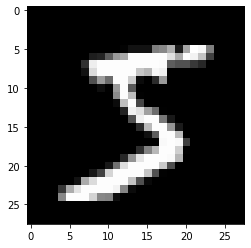

In [7]:
image,label=dataset[0]
plt.imshow(image,cmap="gray")
print("Label:",label)

In [8]:
import torchvision.transforms as transforms
dataset=MNIST(root="data/",train=True,transform=transforms.ToTensor())
img_tensor,label=dataset[0]
print(img_tensor.shape)

torch.Size([1, 28, 28])


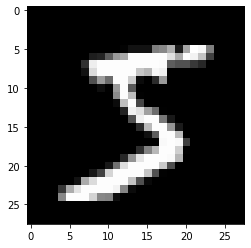

In [9]:
plt.imshow(img_tensor[0],cmap="gray")

In [10]:
def split_indices(n,val_pct):
    n_val=int(val_pct*n)
    idx=np.random.permutation(n)
    return idx[n_val:],idx[:n_val]

In [11]:
train_indices,val_indices=split_indices(len(dataset),val_pct=0.2)

In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [13]:
batch_size=100
train_sampler=SubsetRandomSampler(train_indices)
train_loader=DataLoader(dataset,batch_size,sampler=train_sampler)

In [14]:

val_sampler=SubsetRandomSampler(val_indices)
val_loader=DataLoader(dataset,batch_size,sampler=val_sampler)

In [15]:
import torch.nn as nn
input_size=28*28
num_classes=10

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [17]:
device=get_default_device()
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device,non_blocking=True)
  

In [18]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [19]:
import torch.nn.functional as F
class DigitFind(nn.Module):
    def __init__(self):
        super().__init__()
        self.fx1=nn.Linear(input_size,128)
        self.fx2=nn.Linear(128,10)
        self.dropout=nn.Dropout(0.2)
        
    def forward(self,xb):
        xb=xb.reshape(-1,784)
        out1=self.dropout(F.relu(self.fx1(xb)))
        out2=self.fx2(out1)
        return out2
        

In [20]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

In [21]:
model=DigitFind()
to_device(model,device)
for images,labels in train_loader:
    output=model(images)
    break
output    

tensor([[ 1.8487e-01, -9.5343e-02,  3.8510e-02, -7.7300e-03,  2.0217e-01,
         -3.5067e-02, -2.4598e-02, -1.9192e-01,  1.5857e-02, -2.4705e-01],
        [ 1.0384e-01, -6.1225e-02, -1.0216e-01, -1.0490e-02, -1.1512e-01,
         -1.9699e-02,  3.1489e-02, -1.5981e-02, -8.1194e-02, -1.0435e-01],
        [ 1.6975e-02,  4.9616e-02, -9.6634e-02,  9.5224e-02,  1.2180e-01,
         -1.3883e-01,  5.8778e-03, -6.7569e-02, -4.1516e-02, -1.0751e-01],
        [ 1.7059e-02,  9.0015e-02, -1.3378e-01, -1.3273e-02, -1.8322e-02,
         -4.8202e-02,  9.1755e-03, -1.5382e-01, -3.7723e-02, -2.4921e-01],
        [ 4.5279e-02,  6.0987e-02, -3.5965e-02, -1.4812e-01,  1.4769e-01,
         -3.2300e-02,  6.8694e-02, -1.5780e-01, -1.0384e-01, -2.2773e-01],
        [ 1.4279e-01, -3.0310e-02, -1.3505e-01, -1.3794e-01,  1.0109e-01,
         -2.4034e-01,  1.2240e-01, -2.9870e-02, -1.6265e-02, -3.4272e-01],
        [ 3.7217e-02,  5.9096e-02, -1.3132e-01, -1.4123e-01, -5.6168e-02,
         -3.8804e-02,  7.1269e-0

In [22]:
probs=F.softmax(output,dim=1)
probs,labels

(tensor([[0.1211, 0.0915, 0.1046, 0.0999, 0.1233, 0.0972, 0.0982, 0.0831, 0.1023,
          0.0786],
         [0.1149, 0.0974, 0.0935, 0.1025, 0.0923, 0.1016, 0.1069, 0.1019, 0.0955,
          0.0933],
         [0.1030, 0.1064, 0.0920, 0.1114, 0.1144, 0.0882, 0.1019, 0.0947, 0.0972,
          0.0910],
         [0.1069, 0.1150, 0.0919, 0.1037, 0.1032, 0.1001, 0.1060, 0.0901, 0.1012,
          0.0819],
         [0.1080, 0.1097, 0.0996, 0.0890, 0.1197, 0.1000, 0.1106, 0.0882, 0.0931,
          0.0822],
         [0.1207, 0.1015, 0.0914, 0.0912, 0.1158, 0.0823, 0.1183, 0.1016, 0.1030,
          0.0743],
         [0.1076, 0.1100, 0.0909, 0.0900, 0.0980, 0.0997, 0.1113, 0.0946, 0.1042,
          0.0936],
         [0.1012, 0.1043, 0.1028, 0.0964, 0.1047, 0.1003, 0.1133, 0.0949, 0.0943,
          0.0878],
         [0.1253, 0.1221, 0.0930, 0.1098, 0.1033, 0.0931, 0.0848, 0.0903, 0.1088,
          0.0694],
         [0.1280, 0.1183, 0.0893, 0.0875, 0.1062, 0.0997, 0.1025, 0.0955, 0.0925,
         

In [23]:
max_probs,pred=torch.max(probs,dim=1)
pred

tensor([4, 0, 4, 1, 4, 0, 6, 6, 0, 0, 0, 0, 4, 0, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4,
        1, 4, 4, 1, 4, 4, 4, 0, 0, 0, 1, 1, 4, 4, 1, 0, 4, 4, 1, 4, 1, 1, 4, 4,
        4, 1, 4, 0, 4, 4, 4, 4, 0, 1, 1, 4, 4, 4, 0, 4, 0, 4, 4, 4, 1, 4, 1, 4,
        4, 4, 1, 4, 0, 4, 4, 1, 4, 1, 6, 4, 1, 1, 4, 4, 1, 1, 4, 0, 1, 4, 7, 0,
        4, 0, 1, 0])

In [24]:
def accuracy(l1,l2):
    return torch.sum(l1==l2).item()/len(l1)

In [25]:
loss_fn=F.cross_entropy


In [26]:
# optimizer
learning_rate=0.003
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)


In [27]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
    preds=model(xb)
    loss=loss_fn(preds,yb)
    if opt:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result=None
    if metric:
        metric_result=metric(preds,yb)
    return loss.item(),len(xb),metric_result


In [28]:
def evaluate(model,loss_func,valid_dl,metric=None):
    with torch.no_grad():
        result=[loss_batch(model,loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl]
        losses,nums,metrics=zip(*result)
        total=np.sum(nums)
        avg_loss=np.sum(np.multiply(losses,nums))/total
        avg_metric=np.sum(np.multiply(metrics,nums))/total
        return avg_loss,total,avg_metric

In [29]:
def accuracy(output,labels):
    _,preds=torch.max(output,dim=1)
    return torch.sum(preds==labels).item()/len(preds)

In [30]:
# val_loss,total,val_acc=evaluate(model,loss_fn,val_loader,metric=accuracy)
# print("Loss : {:.4f} , Accuracy : {:.4f}".format(val_loss,val_acc))
torch.cuda.is_available()

False

In [31]:
def fit(epochs,model,loss_fn,opt,train_dl,valid_dl,metric=None):
    for epoch in range(epochs):
        for xb,yb in train_dl:
            loss,_,_=loss_batch(model,loss_fn,xb,yb,opt)
        result=evaluate(model,loss_fn,valid_dl,metric)  
        val_loss,total,val_metric=result
        if metric:
            print("Epoch [{}/{}] , Loss : {:.4f}, {} : {:.4f}".format(epoch+1,epochs,val_loss,metric.__name__,val_metric))
        else:
            print("Epoch [{}/{}] , Loss : {:.4f}".format(epoch+1,epochs))

In [32]:
model=DigitFind()
model.to(device)
optimizer=optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
fit(11,model,F.cross_entropy,optimizer,train_loader,val_loader,accuracy)


Epoch [1/11] , Loss : 0.3630, accuracy : 0.8927
Epoch [2/11] , Loss : 0.2867, accuracy : 0.9157
Epoch [3/11] , Loss : 0.2379, accuracy : 0.9305
Epoch [4/11] , Loss : 0.2069, accuracy : 0.9400
Epoch [5/11] , Loss : 0.1849, accuracy : 0.9485
Epoch [6/11] , Loss : 0.1726, accuracy : 0.9500
Epoch [7/11] , Loss : 0.1615, accuracy : 0.9536
Epoch [8/11] , Loss : 0.1519, accuracy : 0.9557
Epoch [9/11] , Loss : 0.1464, accuracy : 0.9568
Epoch [10/11] , Loss : 0.1389, accuracy : 0.9577
Epoch [11/11] , Loss : 0.1358, accuracy : 0.9599


In [33]:
# val_sampler=SubsetRandomSampler(val_indices)

test_loader=DataLoader(test_dataset,batch_size=200)
test_loader=DeviceDataLoader(test_loader,device)


In [34]:
# test_loader=DataLoader(test_dataset,batch_size=200)
test_loss,total ,test_acc=evaluate(model,loss_fn,test_loader,metric=accuracy)
print("Loss: {:.4f}, Accuracy : {:.4f}".format(test_loss,test_acc))

Loss: 0.1219, Accuracy : 0.9621


**Saving the model**

In [35]:
torch.save(model.state_dict(),"digit_find.pth")
model.state_dict()

OrderedDict([('fx1.weight',
              tensor([[-0.0313,  0.0146, -0.0346,  ...,  0.0155, -0.0224,  0.0098],
                      [ 0.0059, -0.0109, -0.0335,  ..., -0.0066, -0.0050,  0.0337],
                      [-0.0161, -0.0118,  0.0310,  ...,  0.0226,  0.0180,  0.0250],
                      ...,
                      [-0.0087, -0.0250,  0.0323,  ...,  0.0215, -0.0187,  0.0190],
                      [-0.0138,  0.0045, -0.0277,  ..., -0.0355,  0.0308, -0.0242],
                      [-0.0137,  0.0258,  0.0040,  ..., -0.0341,  0.0331,  0.0234]])),
             ('fx1.bias',
              tensor([ 0.1554,  0.0908,  0.0049,  0.0941,  0.0508, -0.0107,  0.0018, -0.2114,
                      -0.0734,  0.0075,  0.1310,  0.0561,  0.1490,  0.1303, -0.0647, -0.0341,
                      -0.0875, -0.0129,  0.1159, -0.0040, -0.0111,  0.0812,  0.0751, -0.0466,
                      -0.0709, -0.0853,  0.0494,  0.0535,  0.1314, -0.0286, -0.0307,  0.2218,
                       0.0442,  0.06